# Introduction
This tutorial illustrates how to (1) introduce daily normailised load profile in a simulation and (2) study voltage profile based on load profile. It allows studying of practical operation of a network. <span style='color:red'>Again please change the working directory in below first</span>.

In [1]:
import os
os.chdir('C:\\Users\\anson\\Desktop\\OpenDss Tutorial\\T4') 

In [2]:
import pandas as pd;
import numpy as np
import opendssdirect as dss
import matplotlib as plt
from cmath import rect
nprect = np.vectorize(rect) #allow element-wise operation in array, detail see https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
dss.Basic.AllowEditor(False)

### (1) Introduce daily normailised load profile
To introduce time-varying behavior of a load, we need to define a loadshape object which characterise the scaling of power consumption across a day. Below are the common parameters to define the loadshape object
- mult: array of scaling factors of active power consumption at the corresponding time instants. e.g. if the nominal load consumption is 1000W, setting mult=[1.5 2] will set the load consumption to be 1.5kW and 2kW at two time instants.
- npts: No of points of load profile. 
- interval: interval between sampling time with unit hour. Note that if we want to do simulation with 1-second resoultion, we need to set interval to be 0.000277 (1/3600)
- Useactual: whether to take mult as the acutal kW drawn instead of multiplier. For instance, if we set Useactual=YES and mult=[1.5 2], then the power drawn by the load will be exactly 1.5kW and 2kW at two time instants

To establish a 0.5hr simulation over a day, we will set npts=48 and interval=0.5


In [3]:
dss.run_command('Redirect simple_load_profile.dss')
dss.run_command('Export monitor m1');#get active and reactive power
dss.run_command('Export monitor m2');#get apparent power
dss.run_command('Export monitor m3');#get voltages

<AxesSubplot:title={'center':'Power factor'}, xlabel='hour'>

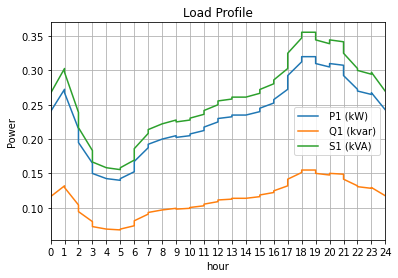

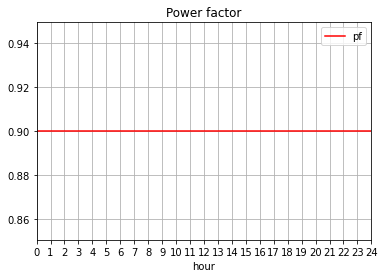

In [39]:
#Read the csv files
m1_data=pd.read_csv("TheveninEquivalent_Mon_m1.csv",header=0);
m2_data=pd.read_csv("TheveninEquivalent_Mon_m2.csv",header=0);

#Create dataframe storing active,reactive,apparent power and power factor
df1=m1_data[['hour',' P1 (kW)',' Q1 (kvar)']];
df2=m2_data[' S1 (kVA)'];
df = pd.concat([df1, df2], axis=1)

pf=np.round(df[' P1 (kW)']/df[' S1 (kVA)'],2)#calculate power factor
df['pf']=pf

#plot the dataframe
df.plot(x='hour',y=df.columns[1:-1],grid=True,xticks=np.arange(0,25),
        title='Load Profile',xlim=[0,24],ylabel='Power')
df.plot(x='hour',y=df.columns[-1],grid=True,xticks=np.arange(0,25),
        title='Power factor',xlim=[0,24],color='r')

We can see the (active) power consumption eqauls to the nominal power (0.25kW) multiplied by the scaling factors (loadshape multiplier) asshown below.

In [5]:
print('loadshape multiplier')
print(np.transpose(dss.LoadShape.PMult()))
print('\n Active power consumption by load')
print(np.transpose(dss.LoadShape.PMult())*0.25)

loadshape multiplier
[0.96 1.09 1.07 0.86 0.78 0.66 0.6  0.57 0.57 0.56 0.57 0.61 0.67 0.75
 0.77 0.8  0.8  0.82 0.81 0.82 0.83 0.85 0.87 0.9  0.92 0.93 0.94 0.94
 0.94 0.96 0.98 1.01 1.03 1.09 1.17 1.25 1.28 1.28 1.24 1.22 1.24 1.23
 1.17 1.09 1.08 1.06 1.07 0.97]

 Active power consumption by load
[0.24   0.2725 0.2675 0.215  0.195  0.165  0.15   0.1425 0.1425 0.14
 0.1425 0.1525 0.1675 0.1875 0.1925 0.2    0.2    0.205  0.2025 0.205
 0.2075 0.2125 0.2175 0.225  0.23   0.2325 0.235  0.235  0.235  0.24
 0.245  0.2525 0.2575 0.2725 0.2925 0.3125 0.32   0.32   0.31   0.305
 0.31   0.3075 0.2925 0.2725 0.27   0.265  0.2675 0.2425]


### (2) Study voltage profile 
Lastly, we will study the effect of introducing load profile to the unbalanced two-bus system in tutorial 3.

In [6]:
dss.run_command('Redirect two_buses_unbalanced_load_profile')
dss.run_command('Export monitor m1');#voltage of 
dss.run_command('Export monitor m2');#get apparent power
dss.run_command('Export monitor m3');#get voltages

<AxesSubplot:title={'center':'Line-to-neutral Voltage Profile'}, xlabel='Time (hr)', ylabel='V_LN (V)'>

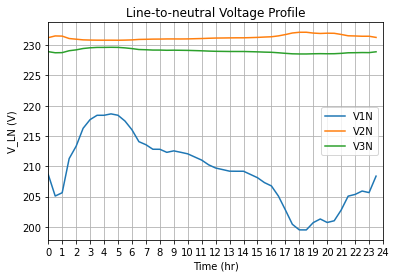

In [38]:
#Read the csv files
m1_data=pd.read_csv("AusOverhead_nr_linegeometry_unbalanced_Mon_m1.csv",header=0);
m2_data=pd.read_csv("AusOverhead_nr_linegeometry_unbalanced_Mon_m2.csv",header=0);
m3_data=pd.read_csv("AusOverhead_nr_linegeometry_unbalanced_Mon_m3.csv",header=0);

#
t=np.arange(0,24,0.5);#time array
V1,V2,V3,VN=m1_data[' V1'],m2_data[' V1'],m3_data[' V1'],m1_data[' V2'];
A1,A2,A3,AN=m1_data[' VAngle1'],m2_data[' VAngle1'],m3_data[' VAngle1'],m1_data[' VAngle2']; 
V_mag=pd.concat([V1,V2,V3,VN],axis=1); V_mag.columns=['V1','V2','V3','VN'];
V_angle=pd.concat([A1,A2,A3,AN],axis=1); V_angle.columns=['A1','A2','A3','AN'];
Z = nprect(V_mag, np.deg2rad(V_angle)); #matrix with 4-columns, complex voltage Z for Z_V1,Z_V2,Z_V3,Z_VN
V_LN=np.stack((Z[:,0],Z[:,1],Z[:,2]),axis=1)-Z[:,3][:,None]; #get line-to-neutral voltage
V_LN=abs(V_LN);
V_LN=pd.DataFrame(V_LN,columns=['V1N','V2N','V3N']);V_LN.insert(loc=0,column='Hour',value=t);
#plot the dataframe
V_LN.plot(x='Hour',y=V_LN.columns[1:],grid=True,xticks=np.arange(0,25),
        title='Line-to-neutral Voltage Profile',xlim=[0,24],xlabel='Time (hr)', ylabel='V_LN (V)')

As observed, the line-to-neutral voltages vary across a day. We can extend this concept to modern power transmisison network with incoperation of realistic data (e.g. load and PV generation profile of houses , transmisison line data), and see if Australia standard is complied with (e.g. Voltage limit).